# Bayesian Sparse Regression in JAX

Using TFP-JAX and Blackjax

Original case study: https://betanalpha.github.io/assets/case_studies/bayes_sparse_regression.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
import jax
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
import blackjax

tfd = tfp.distributions
jdc = tfp.distributions.JointDistributionCoroutineAutoBatched

rng = jax.random.PRNGKey(20230301)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Data Generation

In [3]:
M, N, alpha0, sigma0, sig_prob0 = 200, 100, 3.0, 1.0, 0.05

rng, key0, key1, key2, key3, key4, key5 = jax.random.split(rng, 7)
X = jax.random.normal(key0, (N, M))
beta0 = jax.random.normal(key1, (M,)) * 0.25
index = jax.random.uniform(key2, (M,)) <= 0.05
beta_replace = jax.random.normal(key3, (index.sum(),)) + 10 * jax.random.choice(
    key4, np.asarray([-1, 1]), (index.sum(),)
)
beta0 = beta0.at[index].set(beta_replace)
y = X @ beta0 + alpha0 + jax.random.normal(key5, (N,)) * sigma0


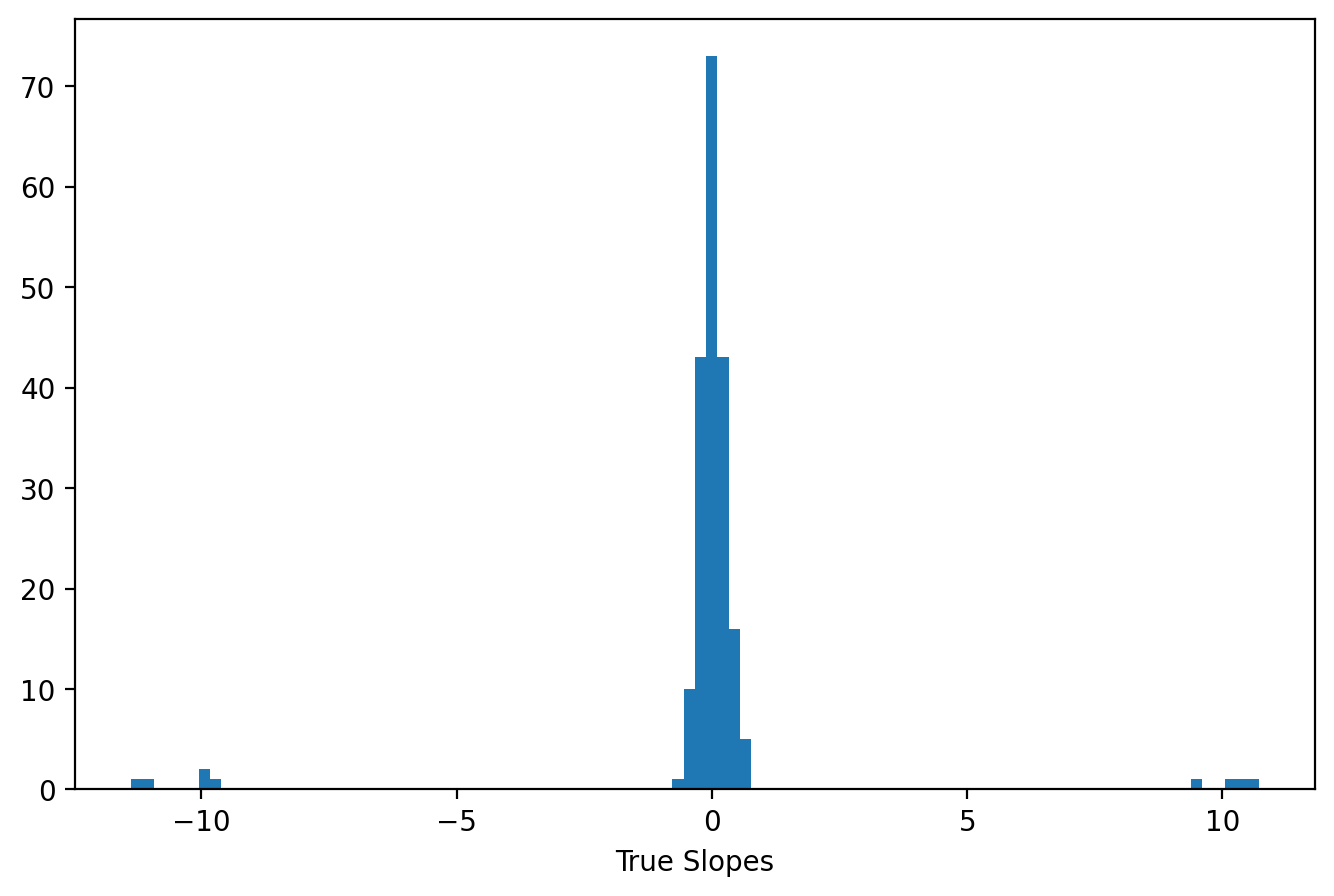

In [4]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.hist(beta0, 100)
ax.set_xlabel("True Slopes")


## Plotting

In [5]:
# Some plotting functions
def plot_slope(beta_post, priorname, n_plot=200):
    beta_post = beta_post.reshape(-1, M).T
    _, ax = plt.subplots(1, 1, figsize=(8, 5))

    ax.step(
        np.arange(M), beta_post[:, -n_plot:], alpha=0.01, color="grey", linestyle="-"
    )
    ax.step(np.arange(M), beta_post.mean(axis=-1), color="r")
    ax.step(beta0, "k", alpha=0.5)
    ax.vlines(np.where(index == 1)[0] - 0.5, -15, 15, linestyle="--", alpha=0.5)
    ax.set_title(priorname)
    ax.set_xlabel("Slope Index")
    ax.set_ylabel("Slope Posterior")
    return ax


In [6]:
def plot_slope_diff(beta_post, priorname, n_plot=200):
    beta_post = beta_post.reshape(-1, M).T
    _, ax = plt.subplots(1, 1, figsize=(8, 5))

    ax.step(
        np.arange(M),
        beta_post[:, -n_plot:] - beta0[..., None],
        alpha=0.01,
        color="grey",
        linestyle="-",
    )
    ax.step(
        np.arange(M),
        beta_post.mean(axis=-1, keepdims=True) - beta0[..., None],
        color="r",
    )
    ax.hlines(0, 0, M, colors="k", alpha=0.5)
    ax.vlines(np.where(index == 1)[0] - 0.5, -15, 15, linestyle="--", alpha=0.5)
    ax.set_title(priorname)
    ax.set_xlabel("Slope Index")
    ax.set_ylabel("Slope Posterior")
    return ax


## Model generation function

In [7]:
def regression_model(design_matrix, beta_generation_fn, **beta_generation_kwargs):
    @jdc
    def model():
        intercept = yield tfd.Normal(0.0, 2.0, name="intercept")
        beta, sigma = yield from beta_generation_fn(**beta_generation_kwargs)
        yhat = design_matrix @ beta + intercept
        yield tfd.Normal(yhat, sigma, name="y")

    return model


In [8]:
def get_join_logdensity(pinned_model):
    # Get the default change of variable bijectors from the model
    bijectors = pinned_model.experimental_default_event_space_bijector()

    def joint_logdensity(unbound_param):
        param = bijectors.forward(unbound_param)
        log_det_jacobian = bijectors.forward_log_det_jacobian(unbound_param)
        return pinned_model.unnormalized_log_prob(param) + log_det_jacobian

    return joint_logdensity, bijectors


## Inference util

In [9]:
n_chains = 4


In [10]:
def inference_loop_multiple_chains(
    rng_key, initial_states, tuned_params, log_prob_fn, num_samples, num_chains
):
    step_fn = blackjax.nuts.kernel()

    def kernel(key, state, **params):
        return step_fn(key, state, log_prob_fn, **params)

    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, infos = jax.vmap(kernel)(keys, states, **tuned_params)
        return states, (states, infos)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_states, keys)

    return (states, infos)


In [11]:
def run_warmpup_and_inference(
    logdensity_fn, seed, init_params, n_warmup=1000, n_samples=1000, n_chains=4
):
    sample_key, warmup_key = jax.random.split(seed, 2)

    warmup = blackjax.window_adaptation(blackjax.nuts, logdensity_fn)

    @jax.vmap
    def call_warmup(seed, param):
        (initial_states, tuned_params), _ = warmup.run(seed, param, n_warmup)
        return initial_states, tuned_params

    keys = jax.random.split(warmup_key, n_chains)
    initial_states, tuned_params = call_warmup(keys, init_params)
    return inference_loop_multiple_chains(
        sample_key, initial_states, tuned_params, logdensity_fn, n_samples, n_chains
    )


In [12]:
def display_diagnostics(posterior_samples):
    ess = jax.tree_map(
        lambda x: blackjax.diagnostics.effective_sample_size(x, 1, 0), posterior_samples
    )
    rhat = jax.tree_map(
        lambda x: blackjax.diagnostics.potential_scale_reduction(x, 1, 0),
        posterior_samples,
    )
    _, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
    ax[0].plot(jax.flatten_util.ravel_pytree(rhat)[0])
    ax[0].hlines(1.1, *ax[0].get_xlim(), linestyle="--", alpha=0.5)
    ax[0].set_title("Rhat")
    ax[1].plot(jax.flatten_util.ravel_pytree(ess)[0])
    ax[1].hlines(
        np.prod(jax.tree_util.tree_flatten(posterior_samples)[0][0].shape[:2]),
        *ax[0].get_xlim(),
        linestyle="--",
        alpha=0.5
    )
    ax[1].set_title("ESS")


## Normal Prior

In [13]:
def normal_prior_fn(beta_sigma):
    sigma = yield tfd.HalfNormal(2.0, name="sigma")
    beta = yield tfd.Sample(tfd.Normal(0.0, beta_sigma), M, name="beta")
    return beta, sigma


### Wide Weakly Informative Prior

In [14]:
normal_model = regression_model(X, normal_prior_fn, beta_sigma=10.0)
pinned_model = normal_model.experimental_pin(y=y)

# Shape check
jax.tree_map(jnp.shape, pinned_model.sample_and_log_weight(4, seed=rng))


(StructTuple(
   intercept=(4,),
   sigma=(4,),
   beta=(4, 200)
 ),
 (4,))

In [15]:
rng, init_key, sample_key = jax.random.split(rng, 3)
init_params = pinned_model.sample_unpinned(n_chains, seed=init_key)
joint_logdensity, bijectors = get_join_logdensity(pinned_model)

rng, sample_key = jax.random.split(rng, 2)
states_normal0, infos = run_warmpup_and_inference(
    joint_logdensity,
    sample_key,
    jax.tree_map(jnp.zeros_like, bijectors.inverse(init_params)),
)

posterior_normal0 = bijectors.forward(states_normal0.position)


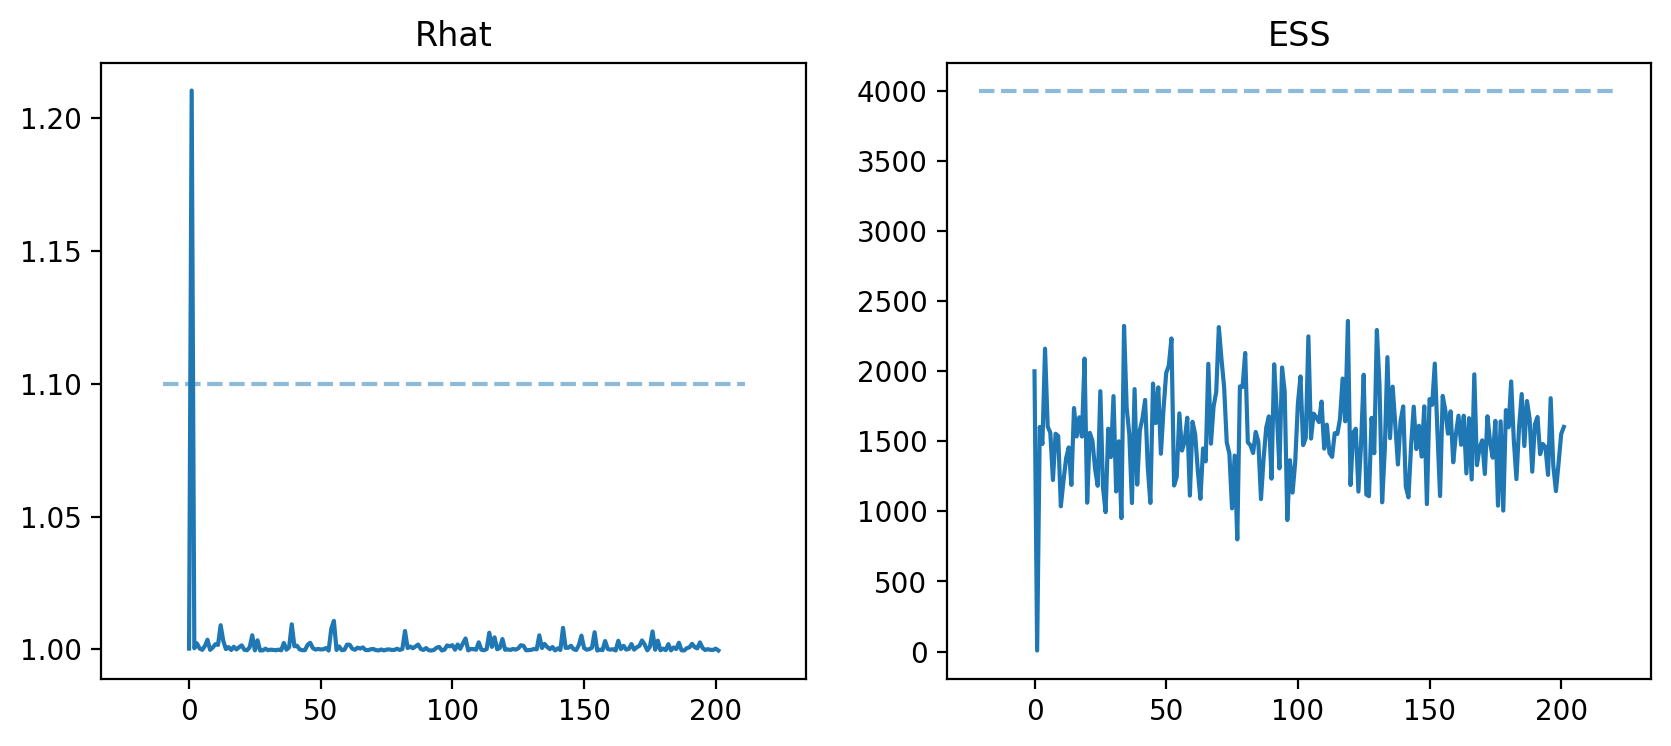

In [16]:
display_diagnostics(posterior_normal0)


<Axes: title={'center': 'Wide Prior'}, xlabel='Slope Index', ylabel='Slope Posterior'>

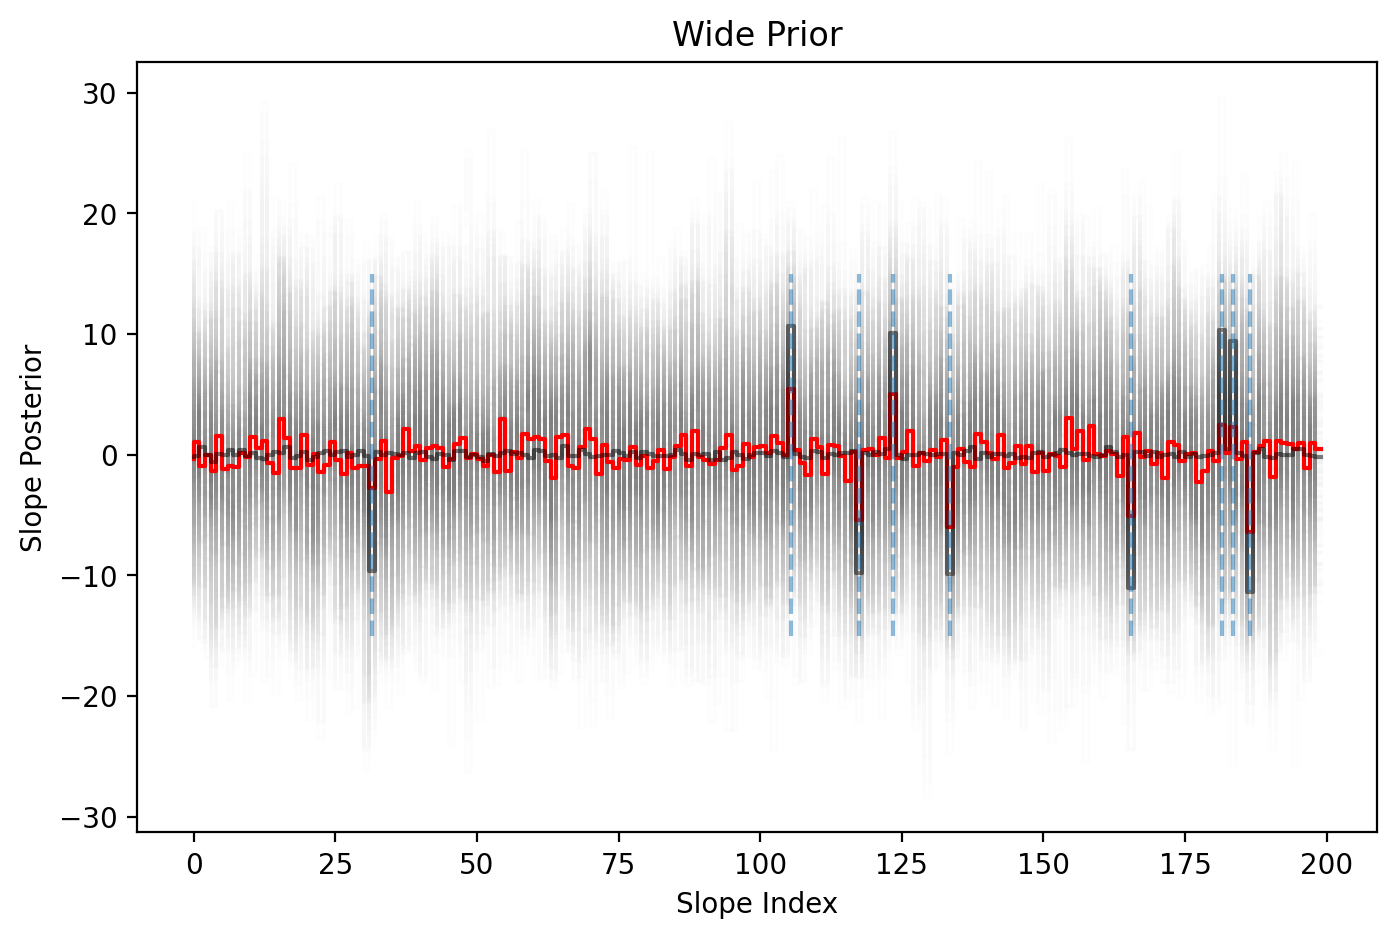

In [17]:
plot_slope(posterior_normal0.beta, "Wide Prior")


<Axes: title={'center': 'Wide Prior'}, xlabel='Slope Index', ylabel='Slope Posterior'>

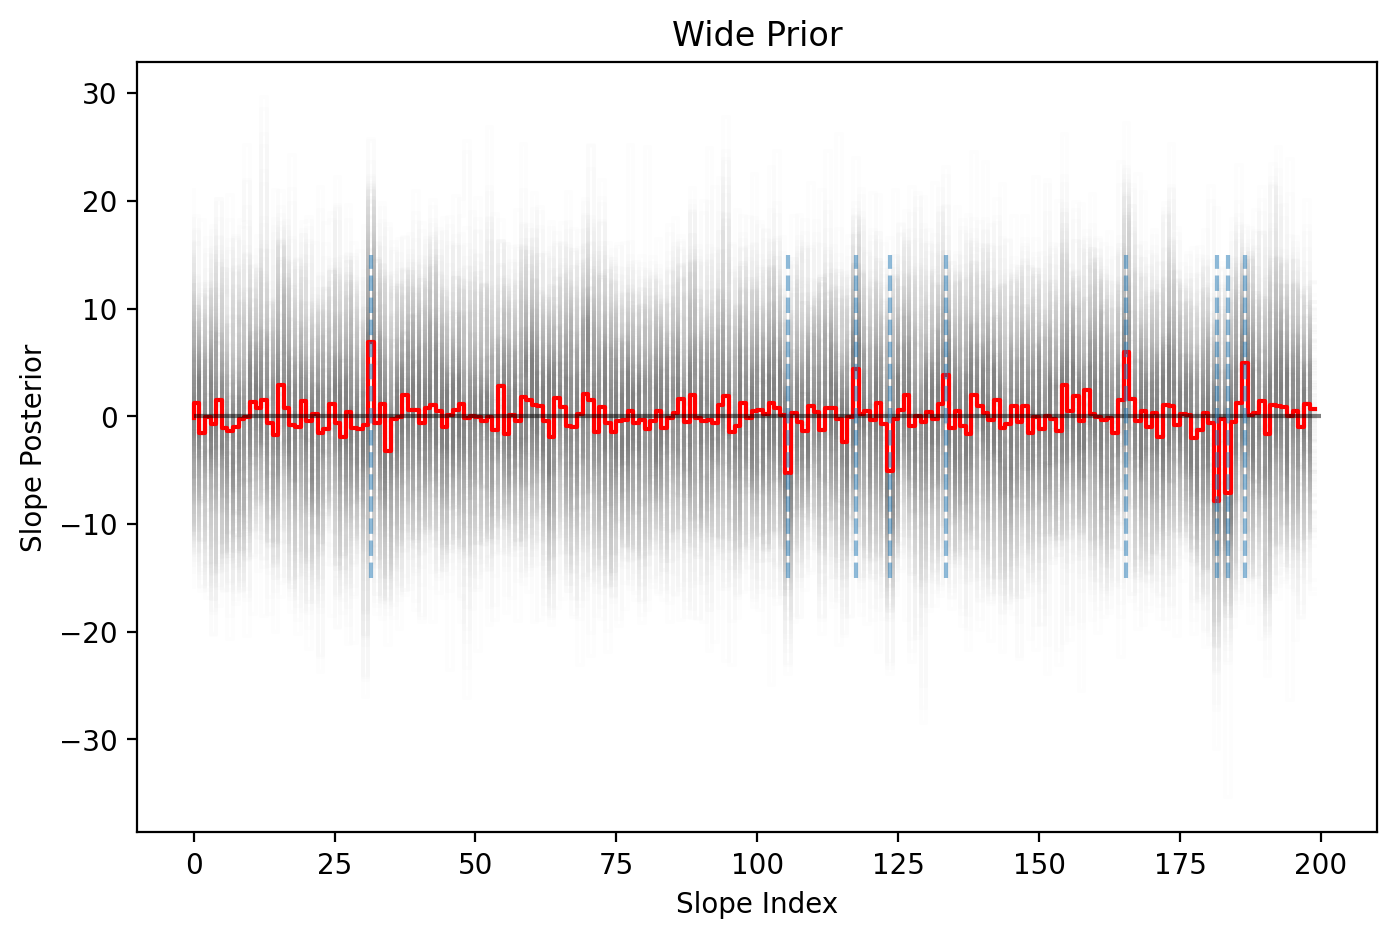

In [18]:
plot_slope_diff(posterior_normal0.beta, "Wide Prior")


### Narrow Weakly Informative Prior

In [19]:
normal_model = regression_model(X, normal_prior_fn, beta_sigma=1.0)
pinned_model = normal_model.experimental_pin(y=y)


In [20]:
rng, init_key, sample_key = jax.random.split(rng, 3)
init_params = pinned_model.sample_unpinned(n_chains, seed=init_key)
joint_logdensity, bijectors = get_join_logdensity(pinned_model)

rng, sample_key = jax.random.split(rng, 2)
states_normal1, infos = run_warmpup_and_inference(
    joint_logdensity,
    sample_key,
    jax.tree_map(jnp.zeros_like, bijectors.inverse(init_params)),
)

posterior_normal1 = bijectors.forward(states_normal1.position)


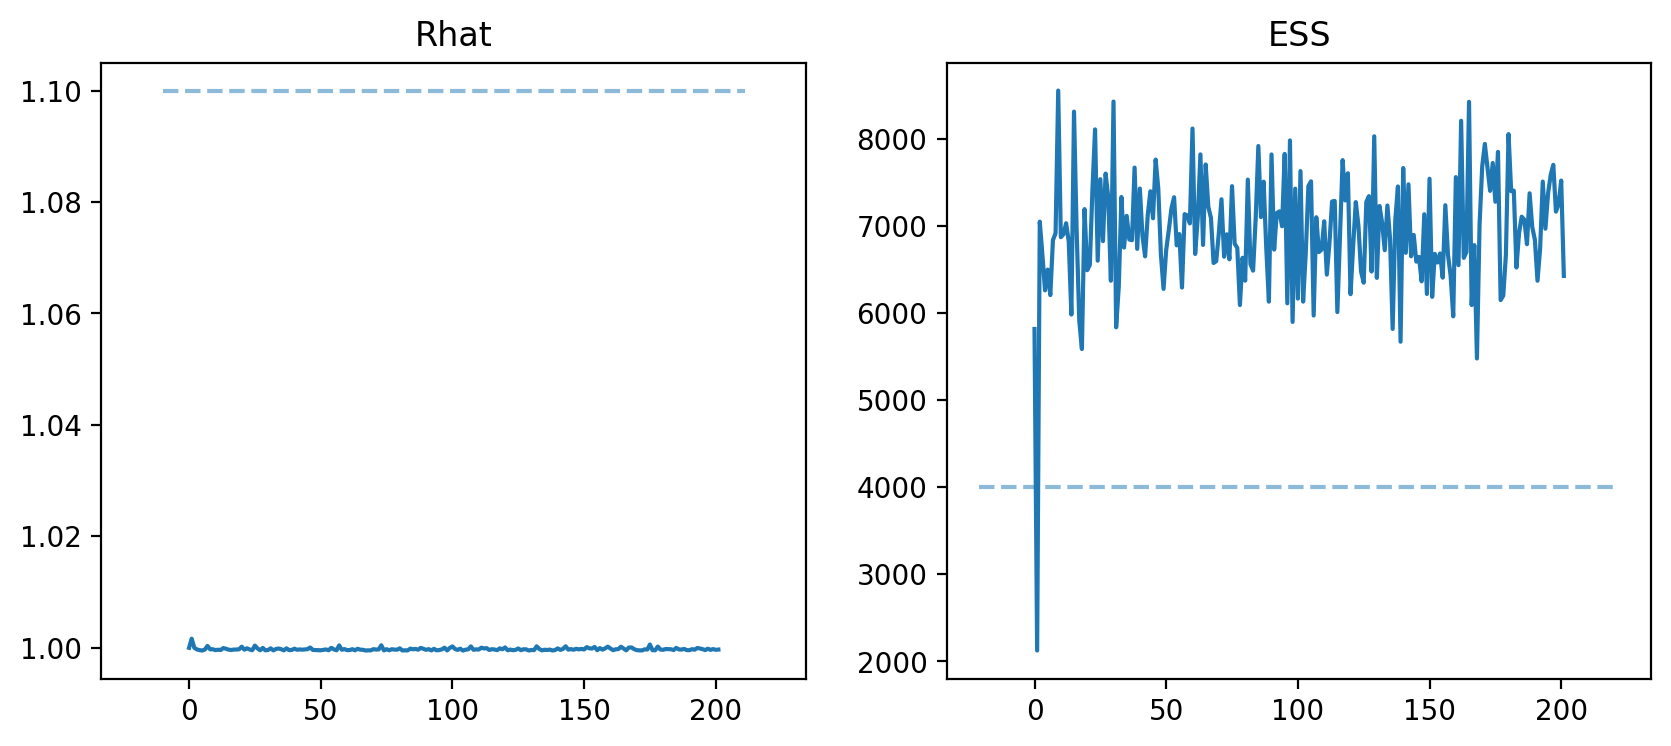

In [21]:
display_diagnostics(posterior_normal1)


<Axes: title={'center': 'Narrow Prior'}, xlabel='Slope Index', ylabel='Slope Posterior'>

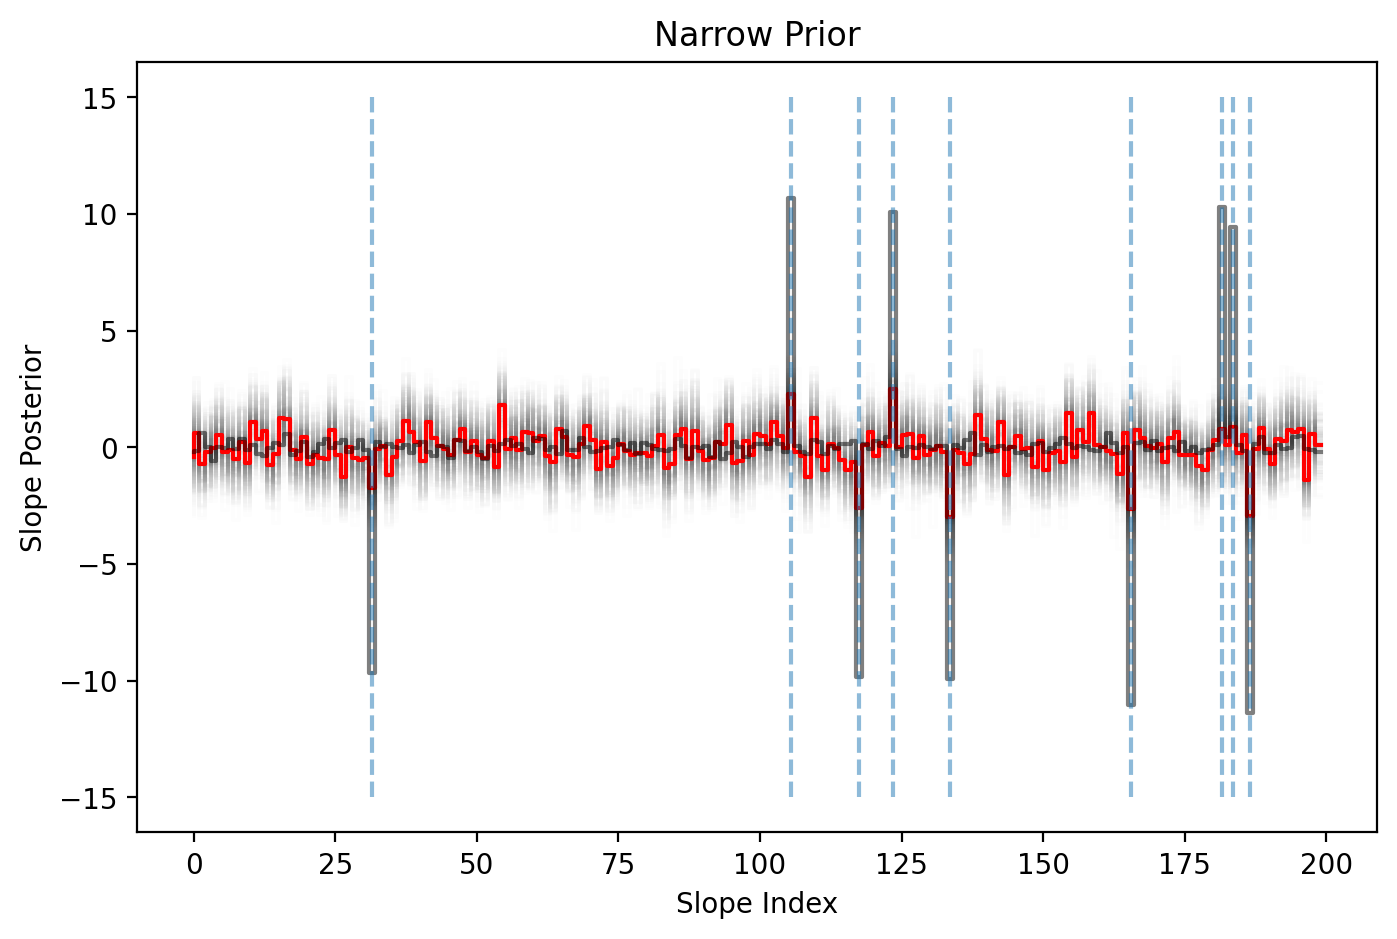

In [22]:
plot_slope(posterior_normal1.beta, "Narrow Prior")


<Axes: title={'center': 'Narrow Prior'}, xlabel='Slope Index', ylabel='Slope Posterior'>

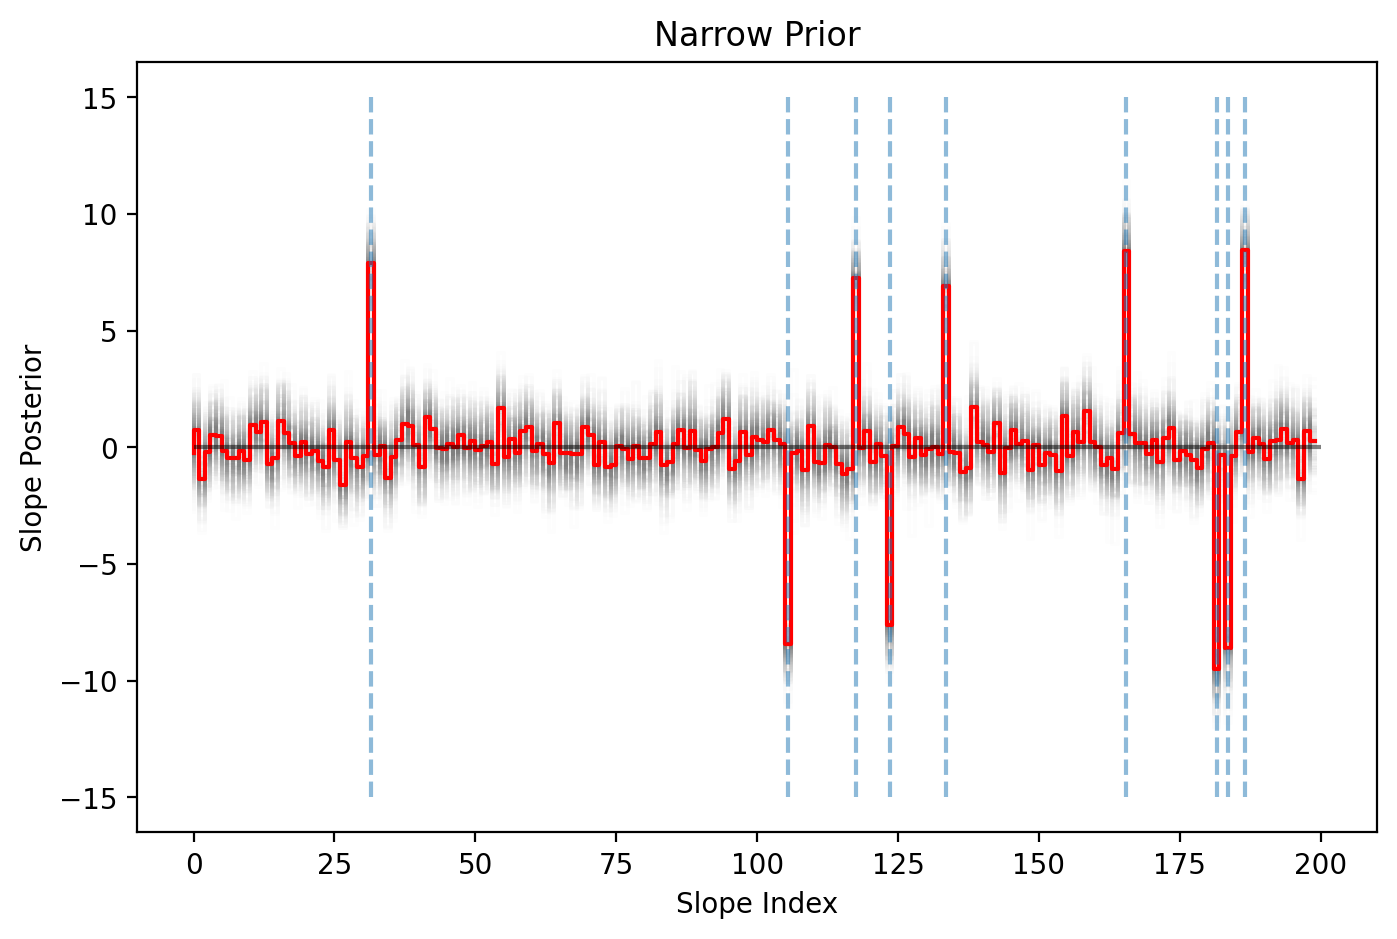

In [23]:
plot_slope_diff(posterior_normal1.beta, "Narrow Prior")


## Laplace Prior

In [24]:
def laplace_prior_fn(beta_sigma=1.0):
    sigma = yield tfd.HalfNormal(2.0, name="sigma")
    beta = yield tfd.Sample(tfd.Laplace(0.0, beta_sigma), M, name="beta")
    return beta, sigma


In [25]:
laplace_model = regression_model(X, laplace_prior_fn)
pinned_model = laplace_model.experimental_pin(y=y)


In [26]:
rng, init_key, sample_key = jax.random.split(rng, 3)
init_params = pinned_model.sample_unpinned(n_chains, seed=init_key)
joint_logdensity, bijectors = get_join_logdensity(pinned_model)

rng, sample_key = jax.random.split(rng, 2)
states_laplace, infos = run_warmpup_and_inference(
    joint_logdensity, sample_key, bijectors.inverse(init_params)
)

posterior_laplace = bijectors.forward(states_laplace.position)


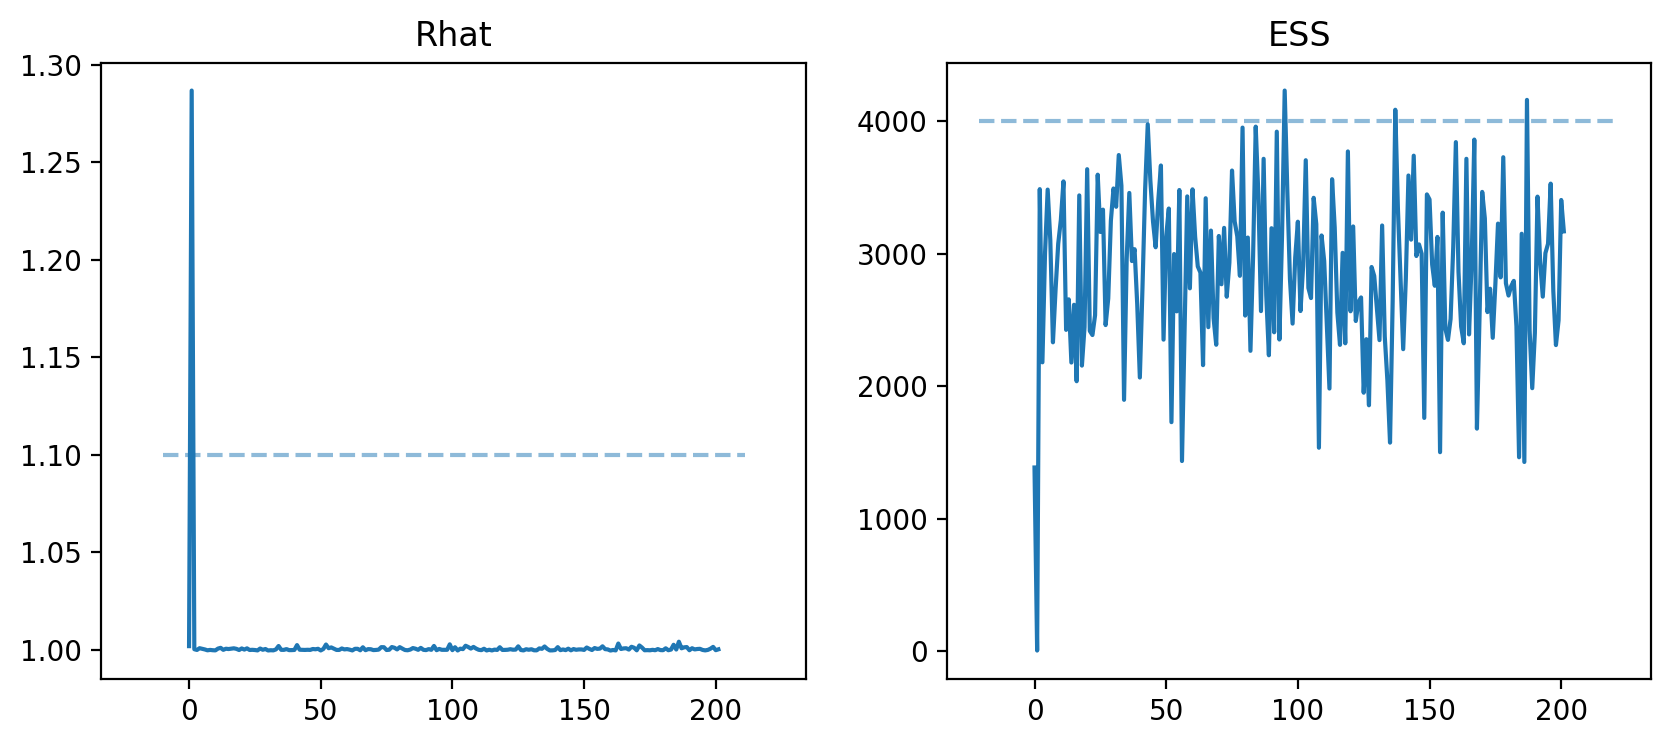

In [27]:
display_diagnostics(posterior_laplace)


<Axes: title={'center': 'Laplace Prior'}, xlabel='Slope Index', ylabel='Slope Posterior'>

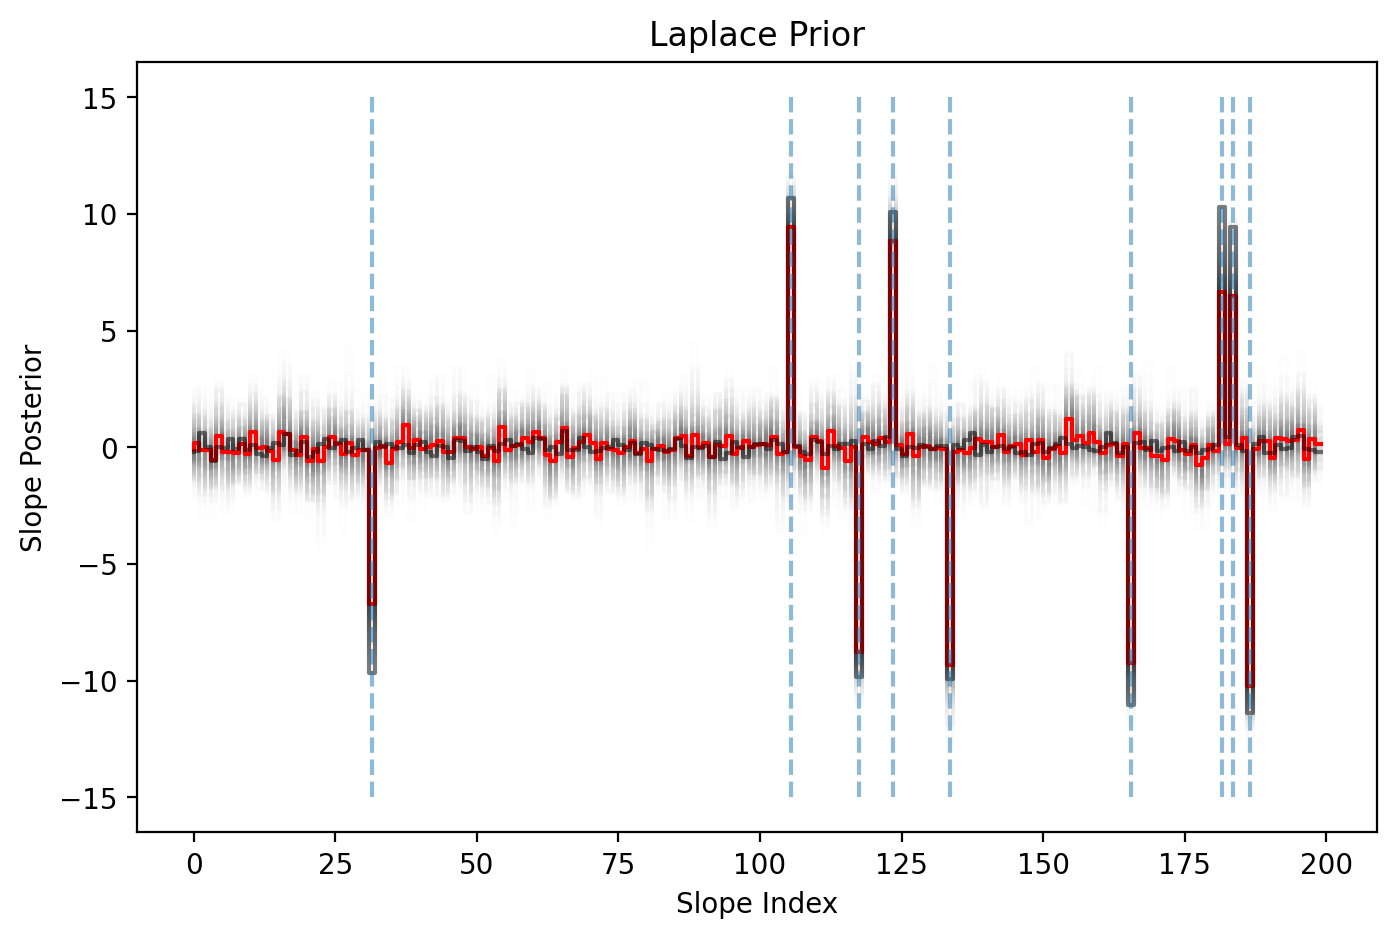

In [28]:
plot_slope(posterior_laplace.beta, "Laplace Prior")


<Axes: title={'center': 'Laplace Prior'}, xlabel='Slope Index', ylabel='Slope Posterior'>

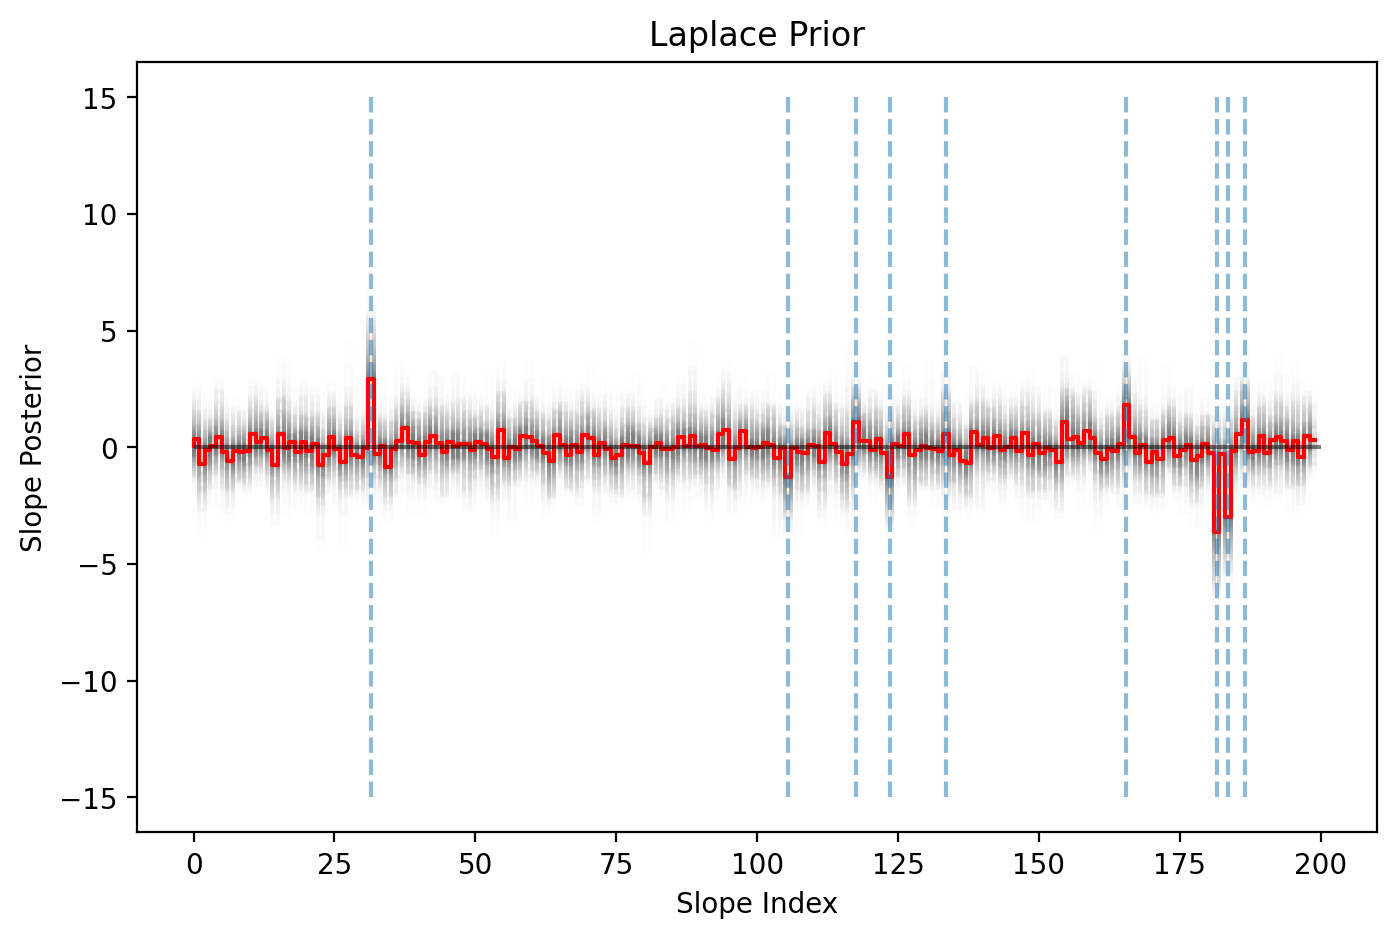

In [29]:
plot_slope_diff(posterior_laplace.beta, "Laplace Prior")


## Horseshoe Prior

In [30]:
def horseshoe_beta_fn(beta_tilde, beta_lambda, sigma, tau_tilde, **kwargs):
    return beta_tilde * beta_lambda * sigma * tau_tilde


def horseshoe_prior_fn():
    sigma = yield tfd.HalfNormal(2.0, name="sigma")
    beta_tilde = yield tfd.Sample(tfd.Normal(0, 1), M, name="beta_tilde")
    beta_lambda = yield tfd.Sample(tfd.HalfCauchy(0, 1), M, name="beta_lambda")
    tau_tilde = yield tfd.HalfCauchy(0, 1, name="tau_tilde")
    beta = horseshoe_beta_fn(beta_tilde, beta_lambda, sigma, tau_tilde)
    return beta, sigma


In [31]:
horseshoe_model = regression_model(X, horseshoe_prior_fn)
pinned_model = horseshoe_model.experimental_pin(y=y)


In [32]:
rng, init_key, sample_key = jax.random.split(rng, 3)
init_params = pinned_model.sample_unpinned(n_chains, seed=init_key)
joint_logdensity, bijectors = get_join_logdensity(pinned_model)

rng, sample_key = jax.random.split(rng, 2)
states_horseshoe, infos = run_warmpup_and_inference(
    joint_logdensity,
    sample_key,
    jax.tree_map(jnp.zeros_like, bijectors.inverse(init_params)),
)

posterior_horseshoe = bijectors.forward(states_horseshoe.position)


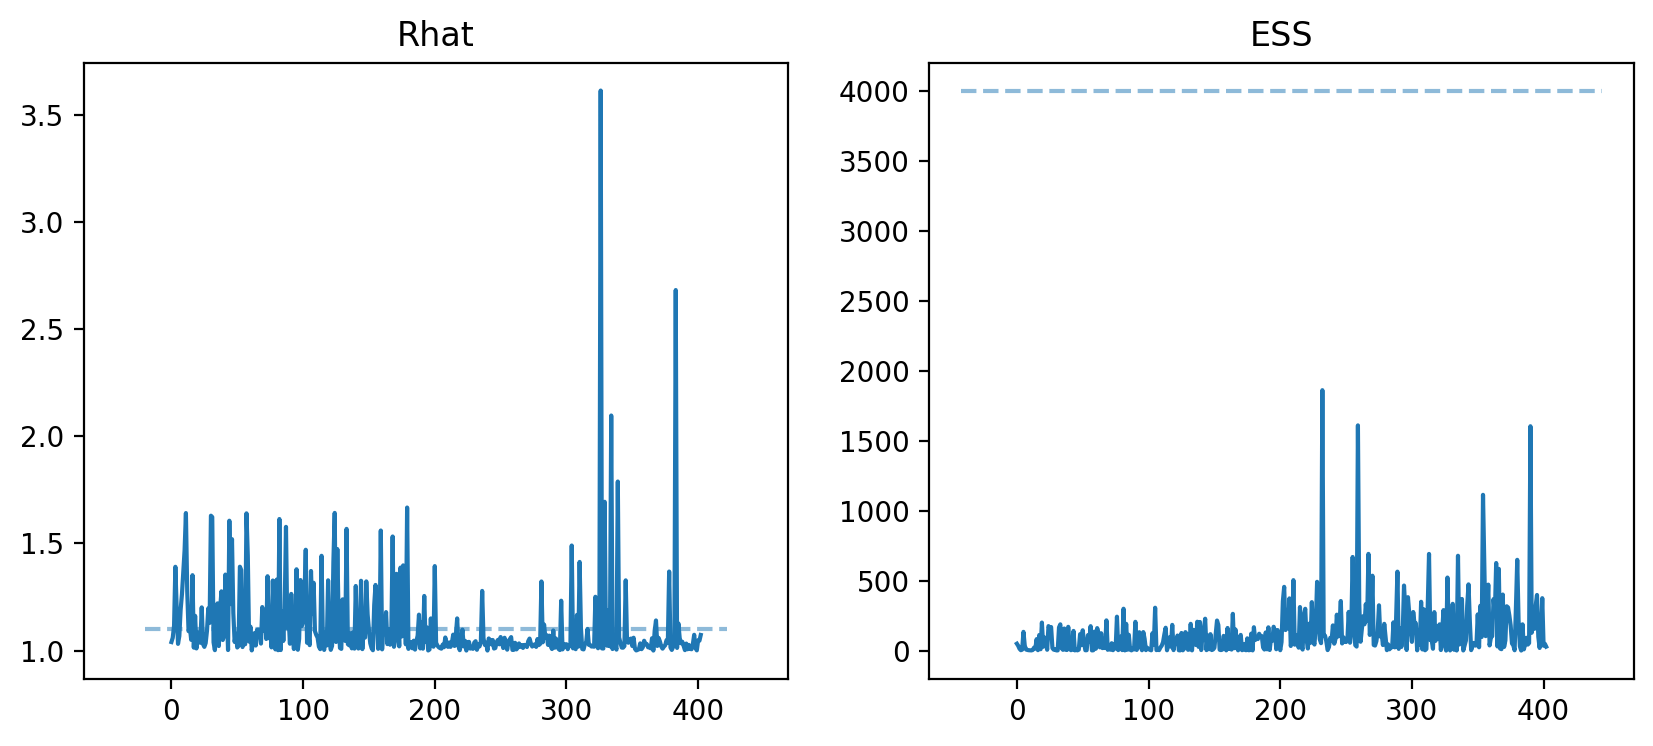

In [33]:
display_diagnostics(posterior_horseshoe)


In [34]:
beta_horseshoe = jax.vmap(jax.vmap(horseshoe_beta_fn))(**posterior_horseshoe._asdict())


<Axes: title={'center': 'Horseshoe Prior'}, xlabel='Slope Index', ylabel='Slope Posterior'>

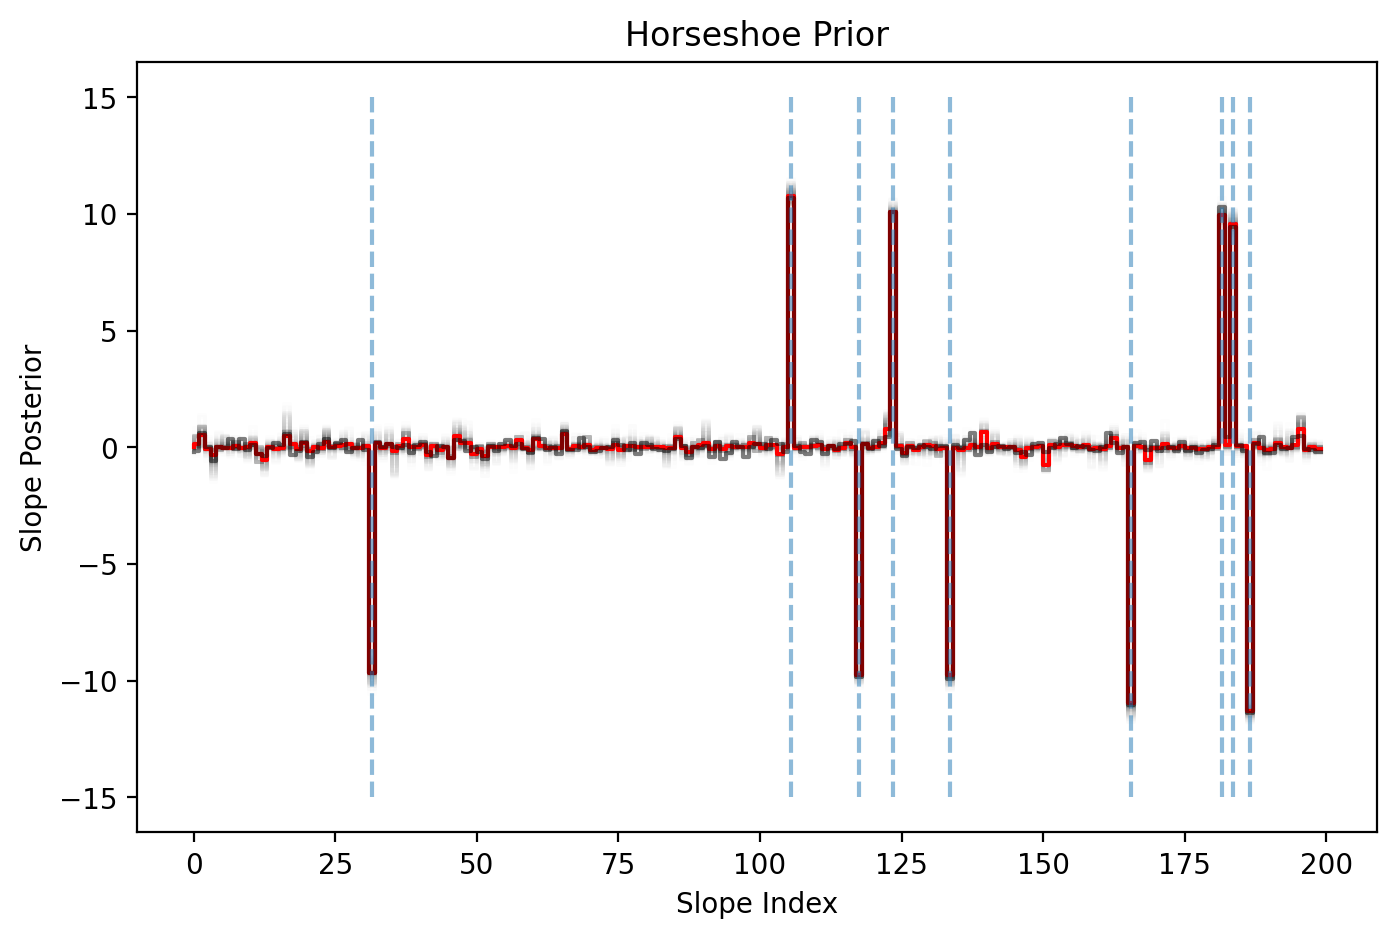

In [35]:
plot_slope(beta_horseshoe, "Horseshoe Prior")


<Axes: title={'center': 'Horseshoe Prior'}, xlabel='Slope Index', ylabel='Slope Posterior'>

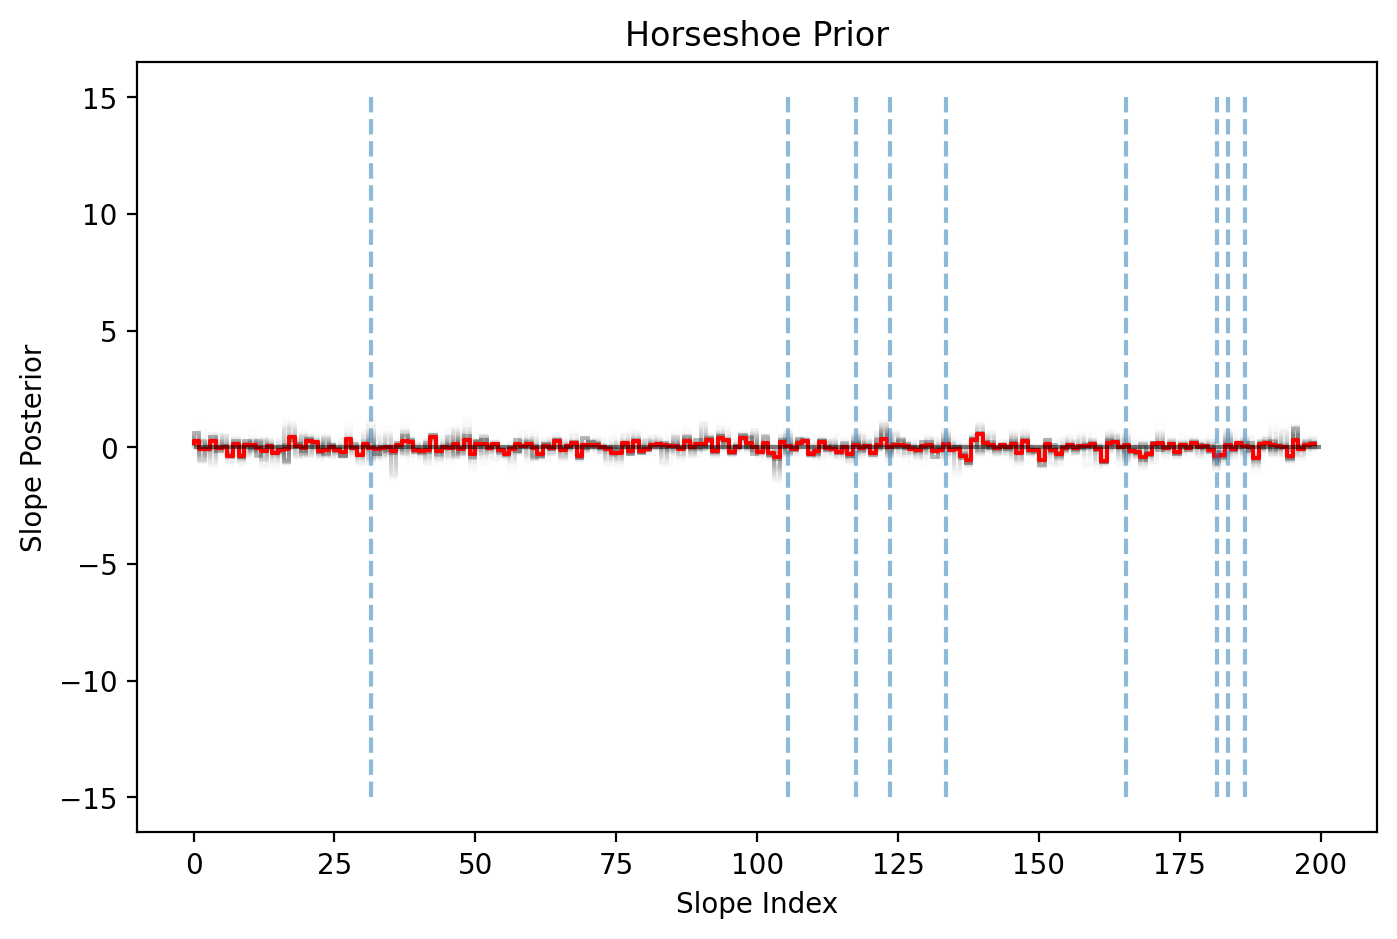

In [36]:
plot_slope_diff(beta_horseshoe, "Horseshoe Prior")


## The Finnish Horseshoe

In [37]:
def finnish_horseshoe_beta_fn(
    slab_scale2, m0, beta_tilde, beta_lambda, sigma, tau_tilde, c2_tilde, **kwargs
):
    tau0 = (m0 / (M - m0)) * (sigma / np.sqrt(1.0 * N))
    tau = tau0 * tau_tilde  # tau ~ cauchy(0, tau0)
    # c2 ~ inv_gamma(half_slab_df, half_slab_df * slab_scale2)
    # Implies that marginally beta ~ student_t(slab_df, 0, slab_scale)
    c2 = slab_scale2 * c2_tilde

    lambda_tilde = jnp.sqrt(
        c2 * jnp.square(beta_lambda) / (c2 + jnp.square(tau) * jnp.square(beta_lambda))
    )
    # beta ~ normal(0, tau * lambda_tilde)
    return tau * lambda_tilde * beta_tilde


def finnish_horseshoe_prior_fn(m0=10.0, slab_scale=3.0, slab_df=25.0):
    """
    m0: Expected number of large slopes
    slab_scale: Scale for large slopes
    slab_df: Effective degrees of freedom for large slopes
    """
    slab_scale2 = slab_scale**2
    half_slab_df = 0.5 * slab_df

    sigma = yield tfd.HalfNormal(2.0, name="sigma")
    beta_tilde = yield tfd.Sample(tfd.Normal(0, 1), M, name="beta_tilde")
    beta_lambda = yield tfd.Sample(tfd.HalfCauchy(0, 1), M, name="beta_lambda")
    tau_tilde = yield tfd.HalfCauchy(0, 1, name="tau_tilde")
    c2_tilde = yield tfd.InverseGamma(half_slab_df, half_slab_df, name="c2_tilde")

    beta = finnish_horseshoe_beta_fn(
        slab_scale2, m0, beta_tilde, beta_lambda, sigma, tau_tilde, c2_tilde
    )
    return beta, sigma


In [38]:
horseshoe_model1 = regression_model(X, finnish_horseshoe_prior_fn)
pinned_model = horseshoe_model1.experimental_pin(y=y)


In [39]:
rng, init_key, sample_key = jax.random.split(rng, 3)
init_params = pinned_model.sample_unpinned(n_chains, seed=init_key)
joint_logdensity, bijectors = get_join_logdensity(pinned_model)

rng, sample_key = jax.random.split(rng, 2)
states_horseshoe1, infos = run_warmpup_and_inference(
    joint_logdensity, sample_key, bijectors.inverse(init_params)
)

posterior_horseshoe1 = bijectors.forward(states_horseshoe1.position)


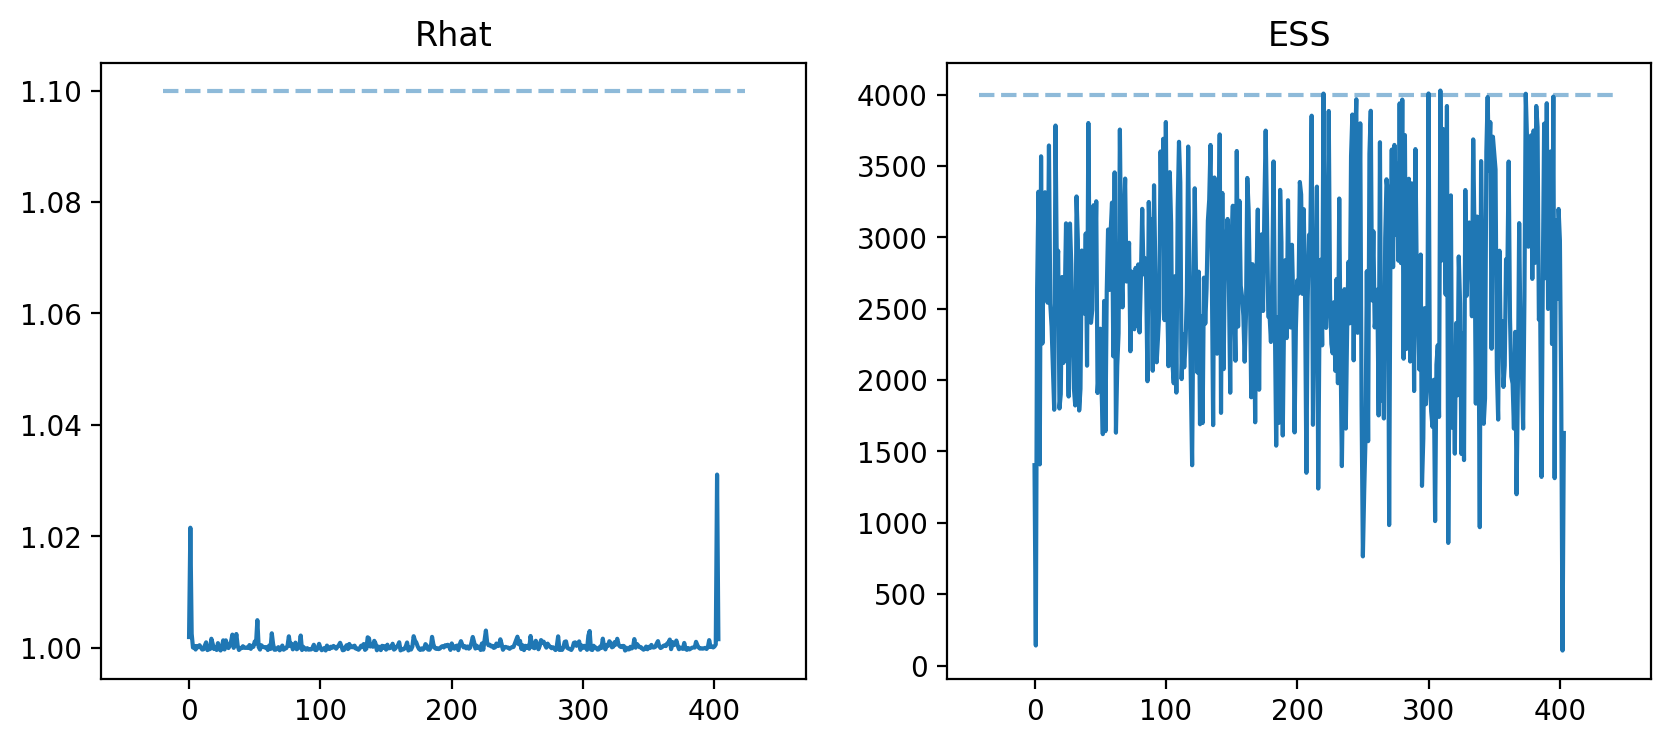

In [40]:
display_diagnostics(posterior_horseshoe1)


In [41]:
beta_horseshoe1 = jax.vmap(
    jax.vmap(lambda *a, **ka: finnish_horseshoe_beta_fn(10, 3.0**2, *a, **ka))
)(**posterior_horseshoe1._asdict())


<Axes: title={'center': 'Finnish Horseshoe Prior'}, xlabel='Slope Index', ylabel='Slope Posterior'>

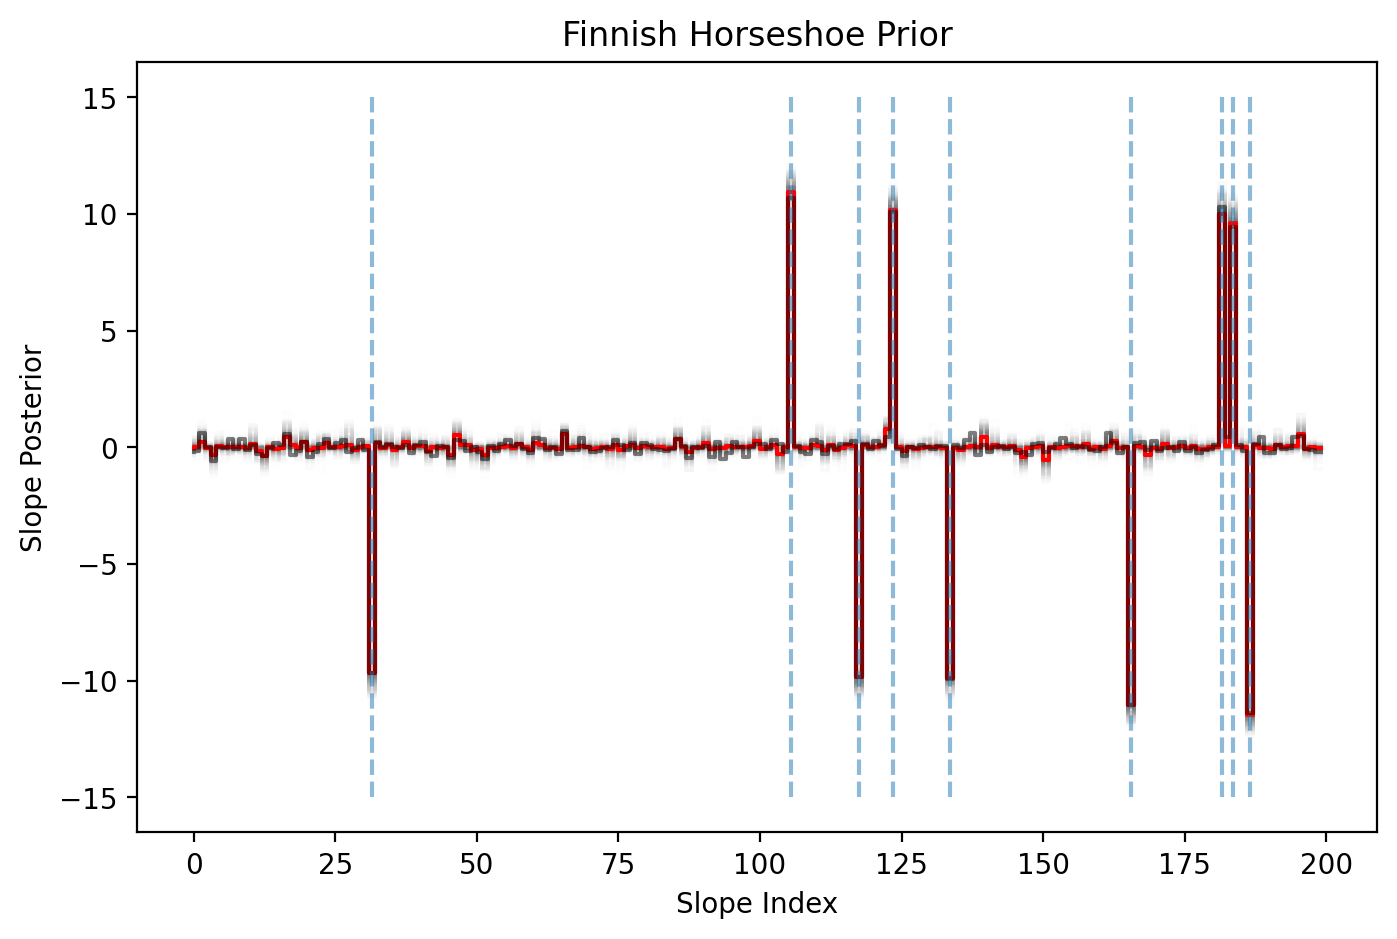

In [42]:
plot_slope(beta_horseshoe1, "Finnish Horseshoe Prior")


<Axes: title={'center': 'Finnish Horseshoe Prior'}, xlabel='Slope Index', ylabel='Slope Posterior'>

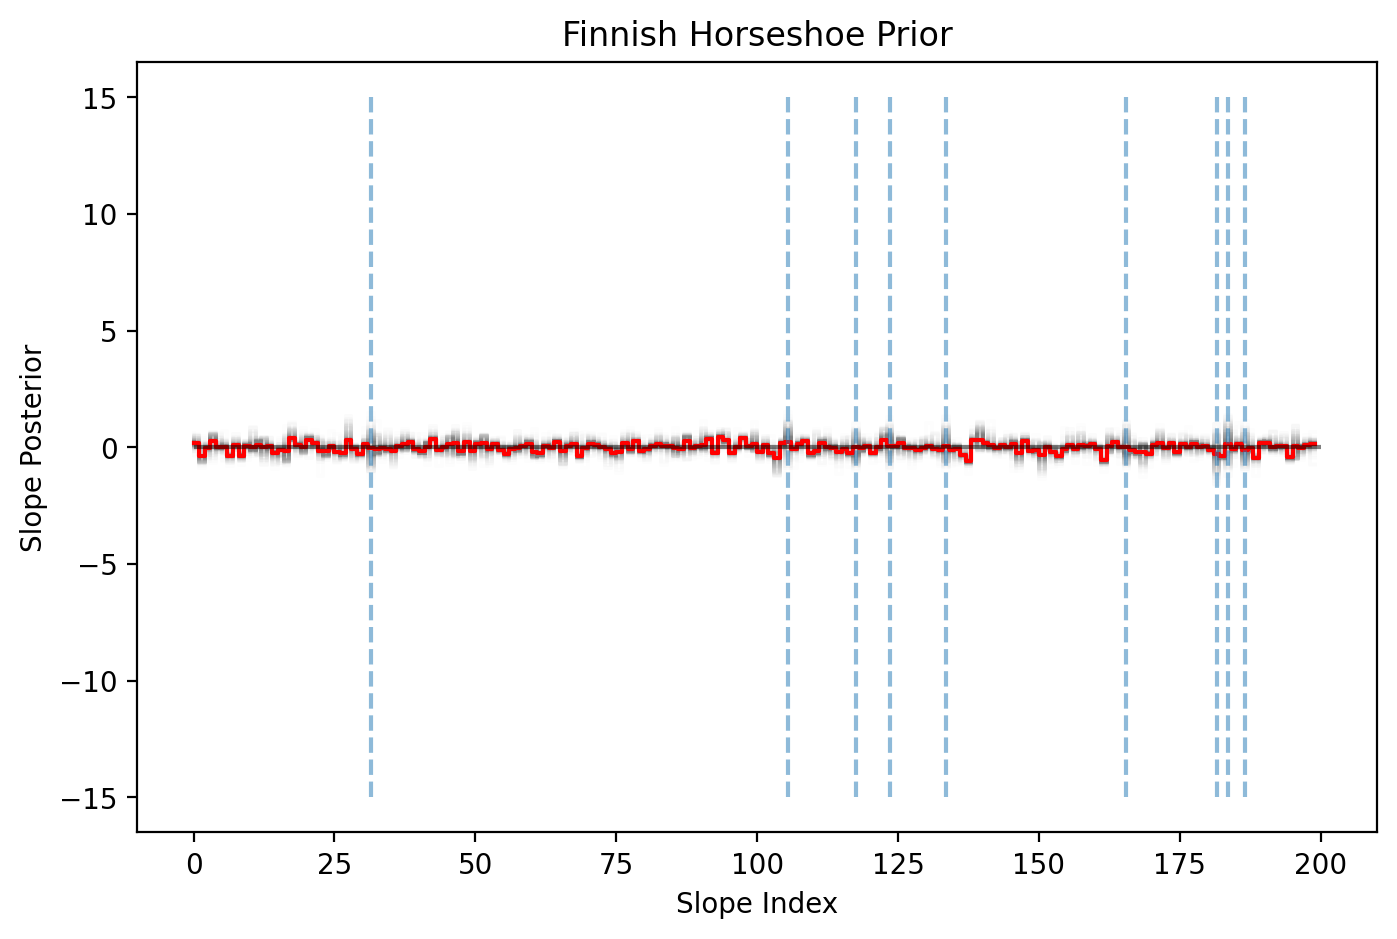

In [43]:
plot_slope_diff(beta_horseshoe1, "Finnish Horseshoe Prior")


## The Finnish Horseshoe v2
From [Practical Hilbert space approximate Bayesian Gaussian processes for probabilistic programming](https://arxiv.org/pdf/2004.11408.pdf).

In [44]:
def finnish_horseshoe_beta_fn2(z, r1_global, r2_global, r1_local, r2_local, **kwargs):
    tau = r1_global * jnp.sqrt(r2_global)
    lambda_h = r1_local * jnp.sqrt(r2_local)
    beta = z * lambda_h * tau
    return beta


def finnish_horseshoe_prior_fn2(scale_global=0.01, nu_global=50.0, nu_local=2.0):
    """
    scale_global: scale for the half-t prior for tau
    nu_global: df for the half-t priors for tau
    nu_local: df for the half-t priors for lambdas (nu_local=1 corresponds to the horseshoe).
    """
    sigma = yield tfd.HalfNormal(2.0, name="sigma")
    # Horseshoe prior effects
    z = yield tfd.Sample(tfd.Normal(0, 1.0), M, name="z")
    r1_local = yield tfd.Sample(tfd.HalfNormal(1.0), M, name="r1_local")
    r2_local = yield tfd.Sample(
        tfd.InverseGamma(0.5 * nu_local, 0.5 * nu_local), M, name="r2_local"
    )
    r1_global = yield tfd.HalfNormal(scale_global * sigma, name="r1_global")
    r2_global = yield tfd.InverseGamma(
        0.5 * nu_global, 0.5 * nu_global, name="r2_global"
    )

    # Horseshoe
    beta = finnish_horseshoe_beta_fn2(z, r1_global, r2_global, r1_local, r2_local)
    return beta, sigma


In [45]:
horseshoe_model2 = regression_model(X, finnish_horseshoe_prior_fn2)
pinned_model = horseshoe_model2.experimental_pin(y=y)


In [51]:
rng, init_key, sample_key = jax.random.split(rng, 3)
init_params = pinned_model.sample_unpinned(n_chains, seed=init_key)
joint_logdensity, bijectors = get_join_logdensity(pinned_model)

rng, sample_key = jax.random.split(rng, 2)
states_horseshoe2, infos = run_warmpup_and_inference(
    joint_logdensity,
    sample_key,
    jax.tree_map(jnp.zeros_like, bijectors.inverse(init_params)),
)

posterior_horseshoe2 = bijectors.forward(states_horseshoe2.position)


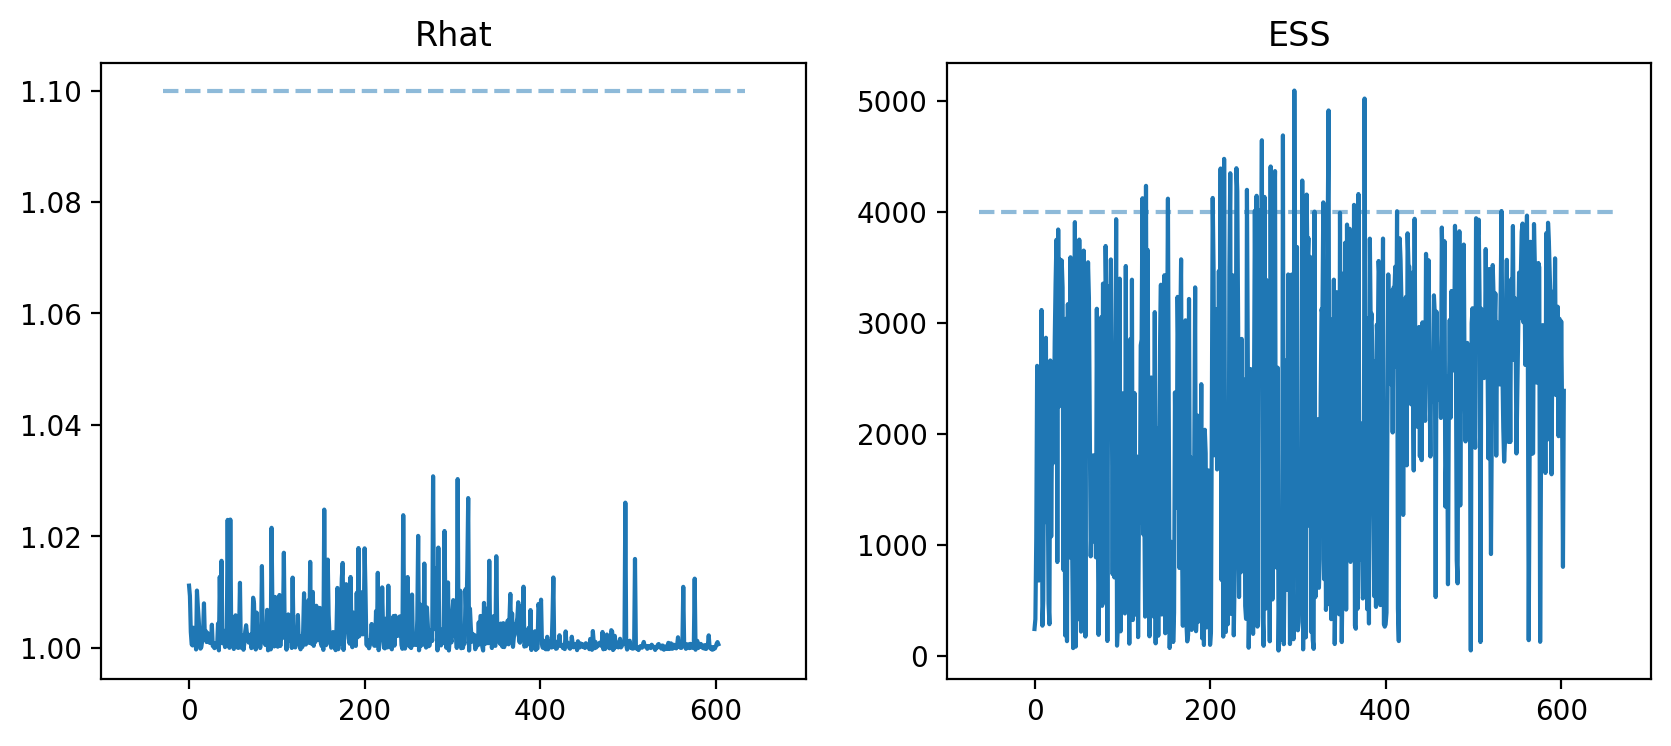

In [52]:
display_diagnostics(posterior_horseshoe2)


In [53]:
beta_horseshoe2 = jax.vmap(jax.vmap(finnish_horseshoe_beta_fn2))(
    **posterior_horseshoe2._asdict()
)


<Axes: title={'center': 'Finnish Horseshoe Prior v2'}, xlabel='Slope Index', ylabel='Slope Posterior'>

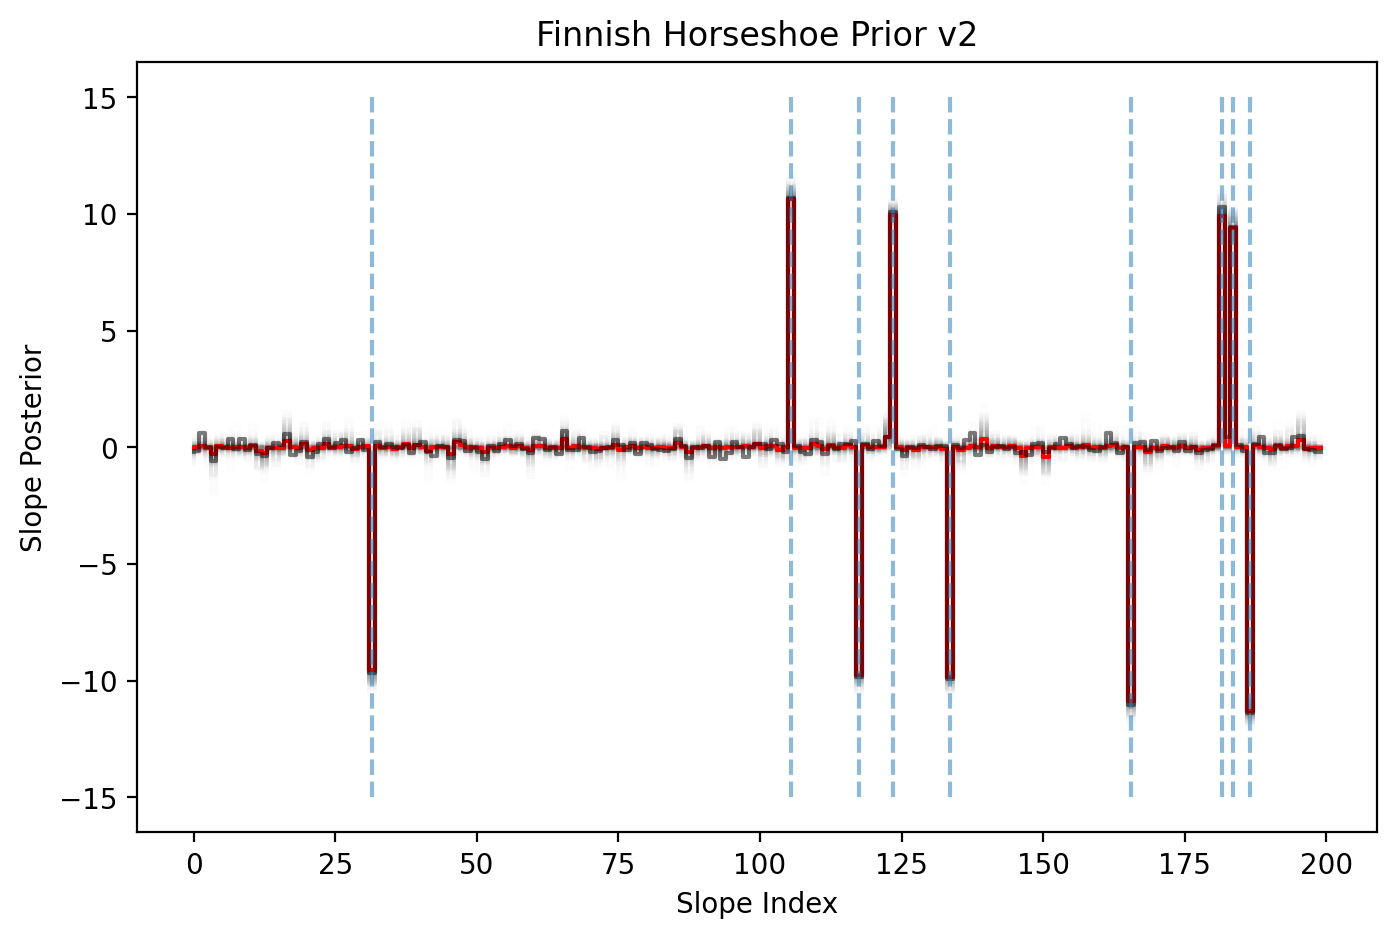

In [54]:
plot_slope(beta_horseshoe2, "Finnish Horseshoe Prior v2")


<Axes: title={'center': 'Finnish Horseshoe Prior v2'}, xlabel='Slope Index', ylabel='Slope Posterior'>

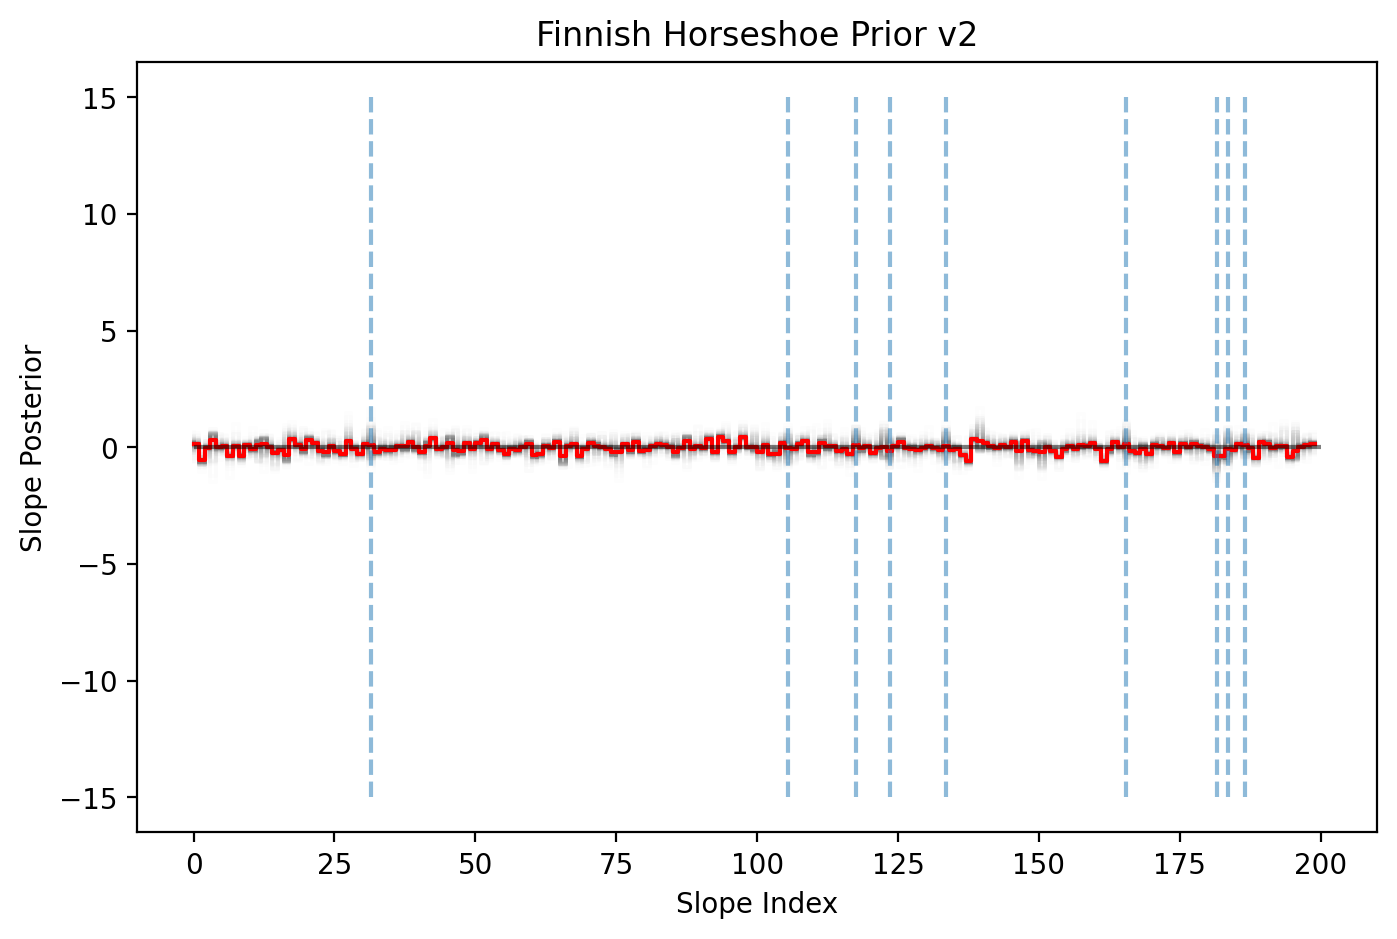

In [55]:
plot_slope_diff(beta_horseshoe2, "Finnish Horseshoe Prior v2")
